# Introduction

This notebook is all about generating the data necessary for training an object detection model based on YOLO by using the NIST Special Database 19's handwritten letters and numbers and creating fake drawn chalk or white boards.

## Important links and information

The famous MNIST dataset is actually a subset of the NIST Special Dataset 19, which contains 810k handwritten alpha-numeric characters, each image being 128 by 128 pixels. We used the 'by_merge' option since we don't particularly care about identifying between a capital O and a lowercase o, and they'd lead to a higher chance of misclassification, which is vital to minimize in the context of text to braille conversion.

* NIST Special Dataset 19: https://www.nist.gov/srd/nist-special-database-19

The user guide for that database shows what the different download configurations mean and give more info about the data arrangement.

* User Guide: https://s3.amazonaws.com/nist-srd/SD19/sd19_users_guide_edition_2.pdf

The EMNIST dataset is similar to the MNIST one but with the entire alphabet as well. The difference between this one and the original one is that it has gone through some preprocessing so that the excess blank pixels are trimmed and its data better matches the MNIST dataset.

* EMNIST Dataset Paper: https://arxiv.org/pdf/1702.05373v2.pdf

In [1]:
# You'll need to install the following libraries to run this notebook
!pip install numpy matplotlib opencv-python seaborn pandas tqdm

In [1]:
# Setup all imports here
from collections import Counter
import random
from time import time
import os
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tqdm.notebook import trange, tqdm_notebook

In [2]:
# Show all matplotlib plots without always calling plt.show()
%matplotlib inline

In [3]:
# Increase the size of the matplotlib figures
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)

# Preliminary analysis of dataset

In [4]:
# Define the data root directory of the dataset
root_dir = os.path.abspath('../datasets/nist-special-db-19/by_merge')
print(root_dir)

/home/tejashah88/projects/info2braille/datasets/nist-special-db-19/by_merge


In [5]:
# List all the character folders from said root directory
!ls ../datasets/nist-special-db-19/by_merge

30  34	38  43_63  47	  4b_6b  4f_6f	53_73  57_77  61  66  71
31  35	39  44	   48	  4c_6c  50_70	54     58_78  62  67  72
32  36	41  45	   49_69  4d_6d  51	55_75  59_79  64  68  74
33  37	42  46	   4a_6a  4e	 52	56_76  5a_7a  65  6e


In [6]:
# Find all character folders from root directory and only keep the valid ascii codes
all_ascii_codes = [folder[len(root_dir) + 1:] for folder in glob(f'{root_dir}/*', recursive=True)]
print(all_ascii_codes)

['66', '72', '54', '50_70', '36', '67', '46', '39', '53_73', '4a_6a', '59_79', '57_77', '41', '4b_6b', '62', '33', '37', '68', '4f_6f', '45', '58_78', '61', '44', '35', '51', '4c_6c', '64', '42', '56_76', '49_69', '4e', '38', '30', '48', '32', '5a_7a', '65', '55_75', '31', '43_63', '52', '74', '4d_6d', '34', '6e', '71', '47']


In [7]:
# Reference to ASCII table: http://www.asciitable.com/
ascii_code = '32'
    
target_char = chr(int(ascii_code[:2], base=16))
print(f'Target character: "{target_char}"')

image_files = glob(f'{root_dir}/{ascii_code}/**/*.png', recursive=True)
print(f'Number of images: {len(image_files)}')

Target character: "2"
Number of images: 40072


In [8]:
# This function takes a 2D array of images and combines them to create a giant image
def combine_2d_images(img_arr):
    (rows, cols) = img_arr.shape[:2]
    img_rows = []
    for img_row in img_arr:
        img_rows += [np.hstack(img_row)]
    combined_img = np.vstack(img_rows)
    return combined_img

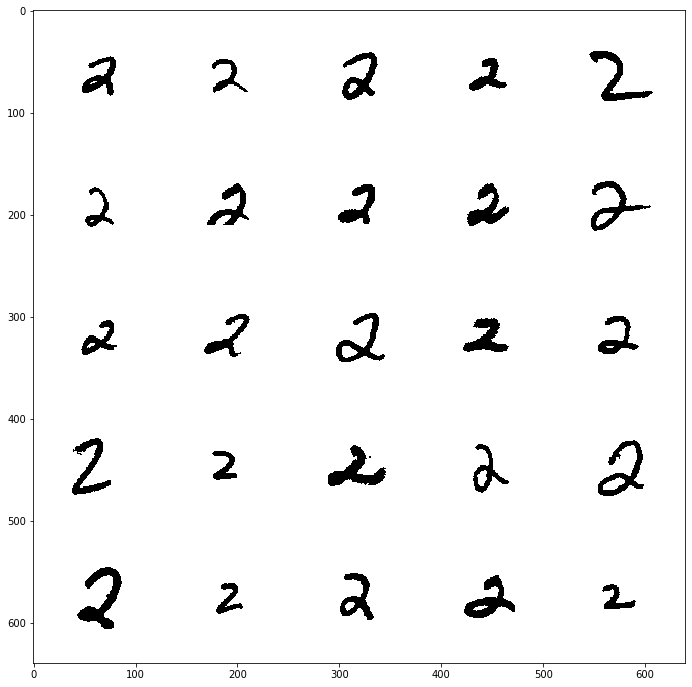

In [9]:
# NOTE: This must be a "square" number (i.e. 1, 4, 9, 16, 25, ...)
NUM_IMAGES = 25

IMG_GRID_SIDE = int(NUM_IMAGES ** 0.5)

rnd_image_paths = random.choices(image_files, k=NUM_IMAGES)
rnd_images = np.array([cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in rnd_image_paths])
rnd_images_grid = rnd_images.reshape((IMG_GRID_SIDE, IMG_GRID_SIDE, *rnd_images.shape[1:]))
combined_img = combine_2d_images(rnd_images_grid)
plt.imshow(combined_img, cmap='gray')

Shape of cropped image: (34, 36)


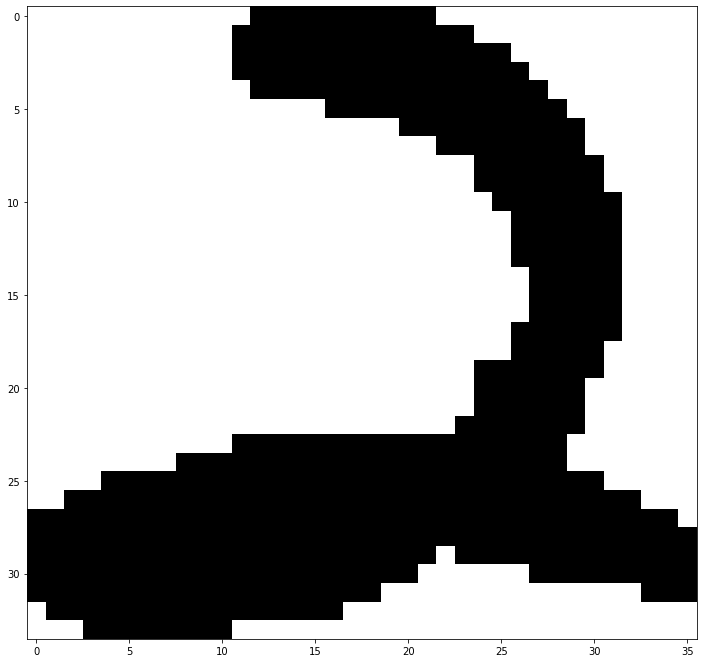

In [10]:
# Show the ROI cropping of a single image
rnd_img_path = random.choice(image_files)
rnd_img = cv2.imread(rnd_img_path, cv2.IMREAD_GRAYSCALE)

idy, idx = np.nonzero(rnd_img == 0)

miny, maxy = np.min(idy), np.max(idy)
minx, maxx = np.min(idx), np.max(idx)

rnd_img_cropped = rnd_img[miny:maxy+1, minx:maxx+1]
plt.imshow(rnd_img_cropped, cmap='gray')
print('Shape of cropped image:', rnd_img_cropped.shape)

In [11]:
# A helper function to load all image paths for each character
def load_all_image_paths(root_dir):
    image_char_groups = []
    all_ascii_codes = [folder[len(root_dir) + 1:] for folder in glob(f'{root_dir}/*', recursive=True)]
    
    for ascii_code in all_ascii_codes:
        target_char = chr(int(ascii_code[:2], base=16))
        image_files = glob(f'{root_dir}/{ascii_code}/**/*.png', recursive=True)
        
        image_char_groups += [(target_char, image_files, len(image_files))]
    
    return pd.DataFrame(
        image_char_groups,
        columns=['char', 'files', 'count']
    ).sort_values(by='count')

In [12]:
char2files_df = load_all_image_paths(root_dir)

In [13]:
char2files_df.head()

,char,files,count
0,f,[/home/tejashah88/projects/info2braille/datase...,2961
46,G,[/home/tejashah88/projects/info2braille/datase...,2964
24,Q,[/home/tejashah88/projects/info2braille/datase...,3018
45,q,[/home/tejashah88/projects/info2braille/datase...,3499
33,H,[/home/tejashah88/projects/info2braille/datase...,3673


In [14]:
loc_min = char2files_df['count'].idxmin()
min_obj = char2files_df.iloc[loc_min]
print(f'Lowest count with character \'{min_obj["char"]}\' having {min_obj["count"]} images')

loc_max = char2files_df['count'].idxmax()
max_obj = char2files_df.iloc[loc_max]
print(f'Lowest count with character \'{max_obj["char"]}\' having {max_obj["count"]} images')

Lowest count with character 'f' having 2961 images
Lowest count with character '4' having 39154 images


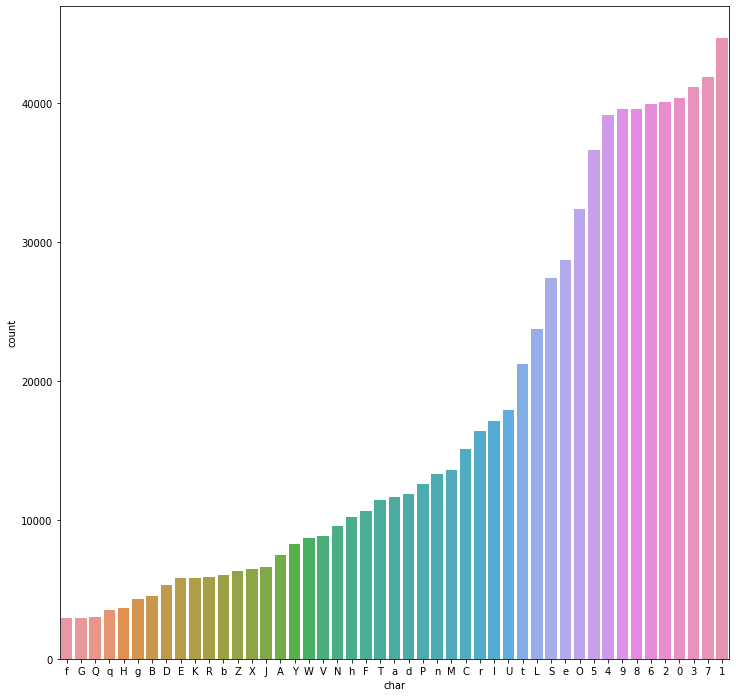

In [15]:
# Let's show a bar plot for how many files are associated with each character
sns.barplot(data=char2files_df, x='char', y='count')

# Synthesizing the data

The basic idea is to take some random chalkboard image, place a bunch of randomly chosen characters such that they don't overlap each other, and generate the corresponding training labeled files for YOLO training.

In [22]:
# A helper function for cropping a character image of its excess padding
def crop_to_roi(img):
    idy, idx = np.nonzero(img == 0)
    
    miny, maxy = np.min(idy), np.max(idy)
    minx, maxx = np.min(idx), np.max(idx)

    return img[miny:maxy+1, minx:maxx+1]

In [23]:
# Returns the time since the starting epoch in nanoseconds, exactly speaking
def now_ns():
    # Note: int() will expand the e+XX notation to its full form
    return int(time() * 10**7)

In [24]:
# Converts a Counter object into a DataFrame for easy bar plotting
def counter_to_df(counter):
    return pd.DataFrame.from_dict(
        counter,
        orient='index'
    ).reset_index().rename(columns={
        'index': 'char',
        0:'count'
    })

In [25]:
# Display all background images that'll be used to generate the fake drawn boards
# Source: https://inscribemag.com/chalkboard-backgrounds-free-photos-vectors/
glob(f'../datasets/fake-boards/*.jpg', recursive=True)

['../datasets/fake-boards/chalkboard-1.jpg',
 '../datasets/fake-boards/chalkboard-4.jpg',
 '../datasets/fake-boards/chalkboard-2.jpg',
 '../datasets/fake-boards/chalkboard-3.jpg']

### Pseudo-code for `generate_images`
```
def generate_images
    repeat for however many number of images are reuired
        select background image from selection of background images
        
        generate image full of zeros with same size as chosen BG image (shadow BG image)
        
        select n random characters from pool of given characters from dataset
        
        for each character from the pool of characters chosen
            pick one image for that character at random and crop it to ROI region
            
            resize it to half its original size
            
            while true
                find a random place to place the image on the board
                
                if the found place is not occupied according to the shadow BG image, then break
            end
            
            draw the character image onto the board with a random color
            
            record all characters and their respective bounding boxes' dimensions for the training data
            
            save the image locally and update the training file
        end
    end
    
    return the generated data and its distribution of characters
```

In [43]:
def generate_images(char2file_dict, background_paths, num_images, num_chars_per_image, output_dir):
    chars = list(char2file_dict.keys())
    char_counter = Counter()
    
    # Ensure the images directory from the output directory is created
    # (otherwise imwrite will refuse to write any images)
    os.makedirs(f'{output_dir}/images', exist_ok=True)
    
    # Write all the character classes for YOLO to expect when training
    with open(f'{output_dir}/classes.txt', 'w') as fp:
        fp.write('\n'.join(chars).strip())

    for i in trange(num_images, desc='Images processed'):
        bbox_labels = []
        generated_data = []

        # Get background image
        chosen_bg_path = random.choice([os.path.abspath(img_path) for img_path in background_paths])
        chosen_bg_raw = cv2.imread(chosen_bg_path, cv2.IMREAD_COLOR)
        chosen_bg = cv2.cvtColor(chosen_bg_raw, cv2.COLOR_BGR2RGB)

        # Generate coverage map to mark space that's already occupied
        shadow_bg = np.zeros(chosen_bg.shape)

        # Get chars to place on image
        chosen_chars = random.choices(chars, k=num_chars_per_image)

        for char in tqdm_notebook(chosen_chars, desc='Chars processed'):
            # Get a random image from each chosen char and crop only ROI
            rnd_img_path = random.choice(char2file_dict[char])
            rnd_img = cv2.imread(rnd_img_path, cv2.IMREAD_GRAYSCALE)
            rnd_img_roi = crop_to_roi(rnd_img)
            
            # TODO: make this more modular
            # Resize it so that we can fit more characters within a small image
            rnd_img_roi = cv2.resize(rnd_img_roi, None, fx = 0.5, fy = 0.5, interpolation = cv2.INTER_AREA)
            sizey, sizex = rnd_img_roi.shape

            # Find valid place to place the character on the board
            maxy, maxx = np.array(shadow_bg.shape[:2]) - np.array(rnd_img_roi.shape)
            
            # This loop handles the logic of 
            while True:
                starty, startx = random.randint(0, maxy), random.randint(0, maxx)
                endy, endx = starty + sizey, startx + sizex

                # For each generated location, check if it interferes with exising chars
                shadow_bg_future = np.zeros(chosen_bg.shape)
                shadow_bg_future[starty:endy+1, startx:endx+1] = 1
                if np.sum( (shadow_bg == 1) & (shadow_bg == shadow_bg_future) ) == 0:
                    break

            # We can now place the char, let's make it transparent to place on background
            shadow_bg[starty:endy+1, startx:endx+1] = 1
            
            # Draw the character onto the board with a random color
            idy, idx = np.nonzero(rnd_img_roi == 0)
            chosen_bg[idy + starty, idx + startx] = [
                random.randint(127, 255),
                random.randint(127, 255),
                random.randint(127, 255),
            ]
            
            # Record the bbox 
            bbox = (startx, starty, endx, endy)
            bbox_labels += [(char, bbox)]

        all_chars_in_image = [label[0] for label in bbox_labels]
        char_counter += Counter(all_chars_in_image)

        entry = {
            'image': chosen_bg,
            'bboxes': bbox_labels,
        }
        
        generated_data += [entry]

        # Save the generated image for YOLO training
        image_path = os.path.abspath(f'{output_dir}/images/{now_ns()}.png')
        cv2.imwrite(image_path, entry['image'])
        annot_line = f'{image_path} '

        # Save the bounding boxes for YOLO training
        for label, bbox in entry['bboxes']:
            label_id = chars.index(label)
            final_arr = [str(item) for item in [*bbox, label_id]]
            annot_line += ','.join(final_arr) + ' '
        annot_line = annot_line.strip() + '\n'
        
        # Save the annotation line
        with open(f'{output_dir}/train.txt', 'a') as fp:
            fp.write(annot_line)
            
    return generated_data, char_counter

In [44]:
# Here, we want to convert the 'char2files_df' DataFrame to a dictionary, with the character
# as the key and the list of files as the value
img_files = {}
for char in char2files_df['char']:
    img_files[char] = char2files_df.loc[char2files_df['char'] == char, 'files'].tolist()[0]

In [45]:
CHALKBOARD_IMAGES = glob(f'../datasets/fake-boards/*.jpg', recursive=True)
DEFAULT_OUTPUT_DIR = '../datasets/generated-written-boards'

In [46]:
generated_data, char_counter = generate_images(
    char2file_dict=img_files,
    background_paths=CHALKBOARD_IMAGES,
    num_images=10,
    num_chars_per_image=100,
    output_dir=DEFAULT_OUTPUT_DIR
)

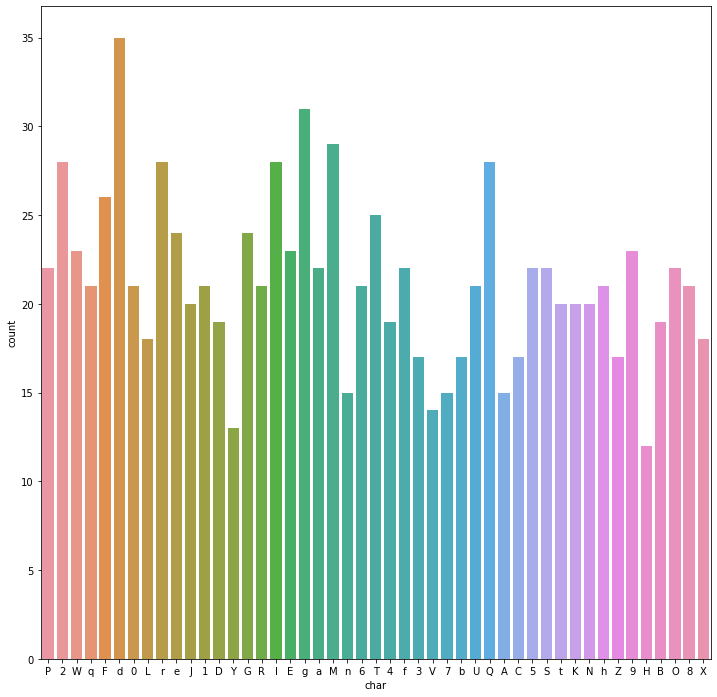

In [47]:
# Plot the character distribution across the entire generated dataset
sns.barplot(data=counter_to_df(char_counter), x='char', y='count')

In [48]:
import sys

top_n_vars = 10

# Source: https://stackoverflow.com/a/51046503
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in globals().items()), key=lambda x: -x[1])[:top_n_vars]:
    print("{:>30}: {:>10}".format(name, sizeof_fmt(size)))

                 char2files_df:    6.6 MiB
                    rnd_images:  400.1 KiB
                  combined_img:  400.1 KiB
                       max_obj:  335.1 KiB
                   image_files:  334.7 KiB
                           _13:  133.9 KiB
                       min_obj:   25.2 KiB
                       rnd_img:   16.1 KiB
                          _i37:    4.0 KiB
                          _i43:    4.0 KiB


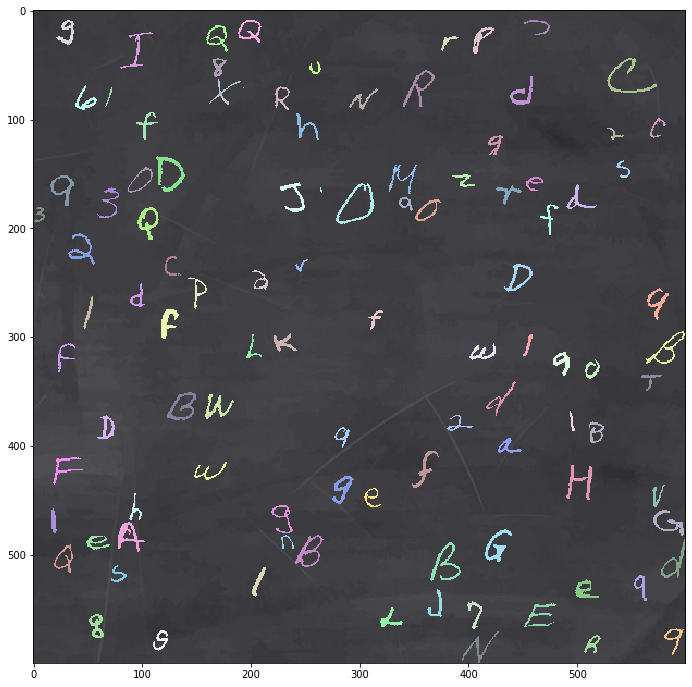

In [49]:
plt.imshow(generated_data[0]['image'])

In [42]:
generated_data[0]['bboxes']

[('6', (413, 217, 433, 242)),
 ('n', (429, 312, 440, 328)),
 ('Q', (211, 131, 239, 159)),
 ('U', (493, 81, 509, 95)),
 ('I', (140, 213, 188, 245)),
 ('O', (42, 94, 56, 107)),
 ('q', (219, 54, 237, 76)),
 ('E', (94, 140, 110, 156)),
 ('S', (513, 560, 528, 574)),
 ('Q', (301, 368, 317, 386)),
 ('V', (235, 336, 246, 354)),
 ('D', (547, 413, 563, 437)),
 ('t', (286, 59, 308, 91)),
 ('A', (218, 303, 230, 317)),
 ('L', (496, 519, 507, 541)),
 ('r', (202, 262, 212, 270)),
 ('W', (545, 327, 569, 351)),
 ('M', (410, 47, 448, 72)),
 ('A', (302, 293, 322, 315)),
 ('W', (323, 96, 343, 110)),
 ('7', (545, 488, 563, 514)),
 ('B', (155, 377, 174, 395)),
 ('7', (411, 126, 431, 156)),
 ('K', (49, 284, 91, 320)),
 ('V', (255, 309, 275, 333)),
 ('I', (159, 433, 167, 444)),
 ('I', (88, 105, 93, 129)),
 ('P', (137, 63, 155, 101)),
 ('d', (155, 330, 179, 366)),
 ('d', (540, 260, 556, 294)),
 ('r', (250, 443, 264, 457)),
 ('e', (316, 120, 337, 142)),
 ('3', (579, 504, 595, 522)),
 ('G', (68, 11, 88, 32)),
 (